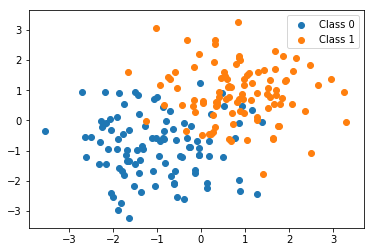

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import pickle
from sklearn.utils import shuffle

np.random.seed(0)

# Artificially generate the data
# data generation code is taken from 
# https://gist.github.com/wiseodd/1c9f5006310f5ee03bd4682b4c03020a
X0 = np.random.randn(100, 2) - 1  # these have gold label of 0
X1 = np.random.randn(100, 2) + 1  # these have gold label of 1
X = np.vstack([X0, X1])
t = np.vstack([np.zeros([100, 1]), np.ones([100, 1])])

# W is the parameter we learn to classify the data point
init_W = np.random.randn(2, 1) * 0.01

# Visualize the points
plt.scatter(X0[:,0], X0[:,1], label='Class 0')
plt.scatter(X1[:,0], X1[:,1], label='Class 1')
plt.legend()

In [14]:
# Shuffle data and perform train/test split

X, t = shuffle(X, t)

X_train, X_test = X[:150], X[:50]
t_train, t_test = t[:150], t[:50]

X_train_tensor = torch.tensor(X_train, dtype=torch.float64)
t_train_tensor = torch.tensor(t_train, dtype=torch.float64)

X_test_tensor = torch.tensor(X_test, dtype=torch.float64)
t_test_tensor = torch.tensor(t_test, dtype=torch.float64)

vg_W = torch.tensor(init_W, dtype=torch.float64, requires_grad=True) # vanilla gradient W
ng_W = torch.tensor(init_W, dtype=torch.float64, requires_grad=True) # natural gradient W

In [15]:
# Update W with vanilla gradient descent

lr = 0.1

def ng_update(x, t_train, W):

    pred = torch.sigmoid(torch.matmul(x, W))
    l = F.binary_cross_entropy(pred, t_train)

    W.grad = None

    l.backward()

    return lr * W.grad.data, l.item()

for iter in range(5):
    vg_W_update, vg_loss = ng_update(X_train_tensor, t_train_tensor, vg_W)

    vg_W.data -= vg_W_update

    print(vg_loss)
    
print(f'Test set loss: {F.binary_cross_entropy(torch.sigmoid(torch.matmul(X_test_tensor, vg_W)), t_test_tensor)}')

0.7010505889337083
0.6594395898323931
0.6231622674449944
0.5914839865349651
0.5637444219028646
Test set loss: 0.5481435452629838


In [16]:
# Update W with natural gradient descent

lr = 0.1

def ng_update(x, t_train, W):

    probs = torch.sigmoid(torch.matmul(x, W))

    logps = []

    for i, p in enumerate(probs):
        if t_train[i] == 1:
            logps.append(torch.log(p))
        else:
            logps.append(torch.log(1 - p))

    grads = []

    for i in range(len(logps)):
        W.grad = None
        logps[i].backward(retain_graph=True)

        grads.append(W.grad.clone().view(-1))

    grads = torch.stack(grads)

    FIM = np.cov(grads.t())

    FIM_inv = np.linalg.inv(FIM)

    FIM_inv = torch.tensor(FIM_inv, dtype=torch.float64)

    pred = torch.sigmoid(torch.matmul(x, W))
    l = F.binary_cross_entropy(pred, t_train)

    W.grad = None

    l.backward()

    return lr * torch.matmul(FIM_inv, W.grad.data), l.item()

for iter in range(5):
    ng_W_update, pt_loss = ng_update(X_train_tensor, t_train_tensor, ng_W)

    ng_W.data -= ng_W_update

    print(pt_loss)

print(f'Test set loss: {F.binary_cross_entropy(torch.sigmoid(torch.matmul(X_test_tensor, ng_W)), t_test_tensor)}')

0.7010505889337083
0.5535321048592613
0.40743645079520563
0.3018352636491892
0.26607391494182586
Test set loss: 0.25924951791129397
